In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from modules.simulation import UniverseSimulator
import configparser

params = {
     "font.family": "serif",
     "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
     "axes.labelsize": 10,
     "font.size": 10,
     "legend.fontsize": 8,
     "xtick.labelsize": 8,
     "ytick.labelsize": 8,
     "text.usetex": True,
     #"figure.figsize": [3.386, 3.386],
     "figure.dpi": 300,
     "savefig.bbox": "tight",
     "savefig.pad_inches": 0.05,
     "axes.linewidth": 0.8,
     "xtick.major.width": 0.8,
     "ytick.major.width": 0.8,
     "xtick.direction": "in",
     "ytick.direction": "in",
    "xtick.top": True,
     "ytick.right": True,
 }
plt.rcParams.update(params)

In [2]:
import configparser
default_config_capish = configparser.ConfigParser()
default_config_capish.read('../config/capish_flagship.ini')

['../config/capish_flagship.ini']

In [3]:
default_config_capish.keys()

KeysView(<configparser.ConfigParser object at 0x7f8424ee30d0>)

In [4]:
import configparser
default_config_capish = configparser.ConfigParser()
default_config_capish.read('../config/capish_flagship.ini')
default_config_capish['parameters']['sigma_Mwl_gal'] = '0.1'
default_config_capish['parameters']['sigma_Mwl_int'] = '0.05'
default_config_capish['parameters']['log10M_min'] = '14.5'
default_config_capish['parameters']['alpha_lambda'] = '3.5'
default_config_capish['parameters']['beta_lambda'] = '1.72'
default_config_capish['parameters']['gamma_lambda'] = '0.0'
default_config_capish['cluster_catalogue']['gaussian_lensing_variable'] = 'log10Mwl'
default_config_capish['cluster_catalogue.mass_observable_relation']['which_relation'] = 'power_law'
default_config_capish['cluster_catalogue']['theory_sigma_Mwl_gal'] = 'True'
default_config_capish['summary_statistics']['use_stacked_sigma_Mwl_gal'] = 'True'
default_config_capish['summary_statistics']['use_stacked_sigma_Mwl_int'] = 'True'
sim = UniverseSimulator(default_config_path = None , default_config = default_config_capish, 
                        variable_params_names = ['Omega_m','sigma8'])

Loading /pbs/throng/lsst/users/cpayerne/capish/modules/cluster/model_log10mWL_Rmin1.0_Rmax5.0_ngal25.0_ShapeNoise0.3_M200matter_cMDuffy08.pkl
Loading /pbs/throng/lsst/users/cpayerne/capish/modules/cluster/model_log10mWL_Rmin1.0_Rmax5.0_ngal25.0_ShapeNoise0.3_M200matter_cMDuffy08.pkl


In [5]:
N, log10M = sim.run_simulation([0.319, 0.81])

In [6]:
N.shape

(5, 4)

Text(0, 0.5, 'log10M_capish')

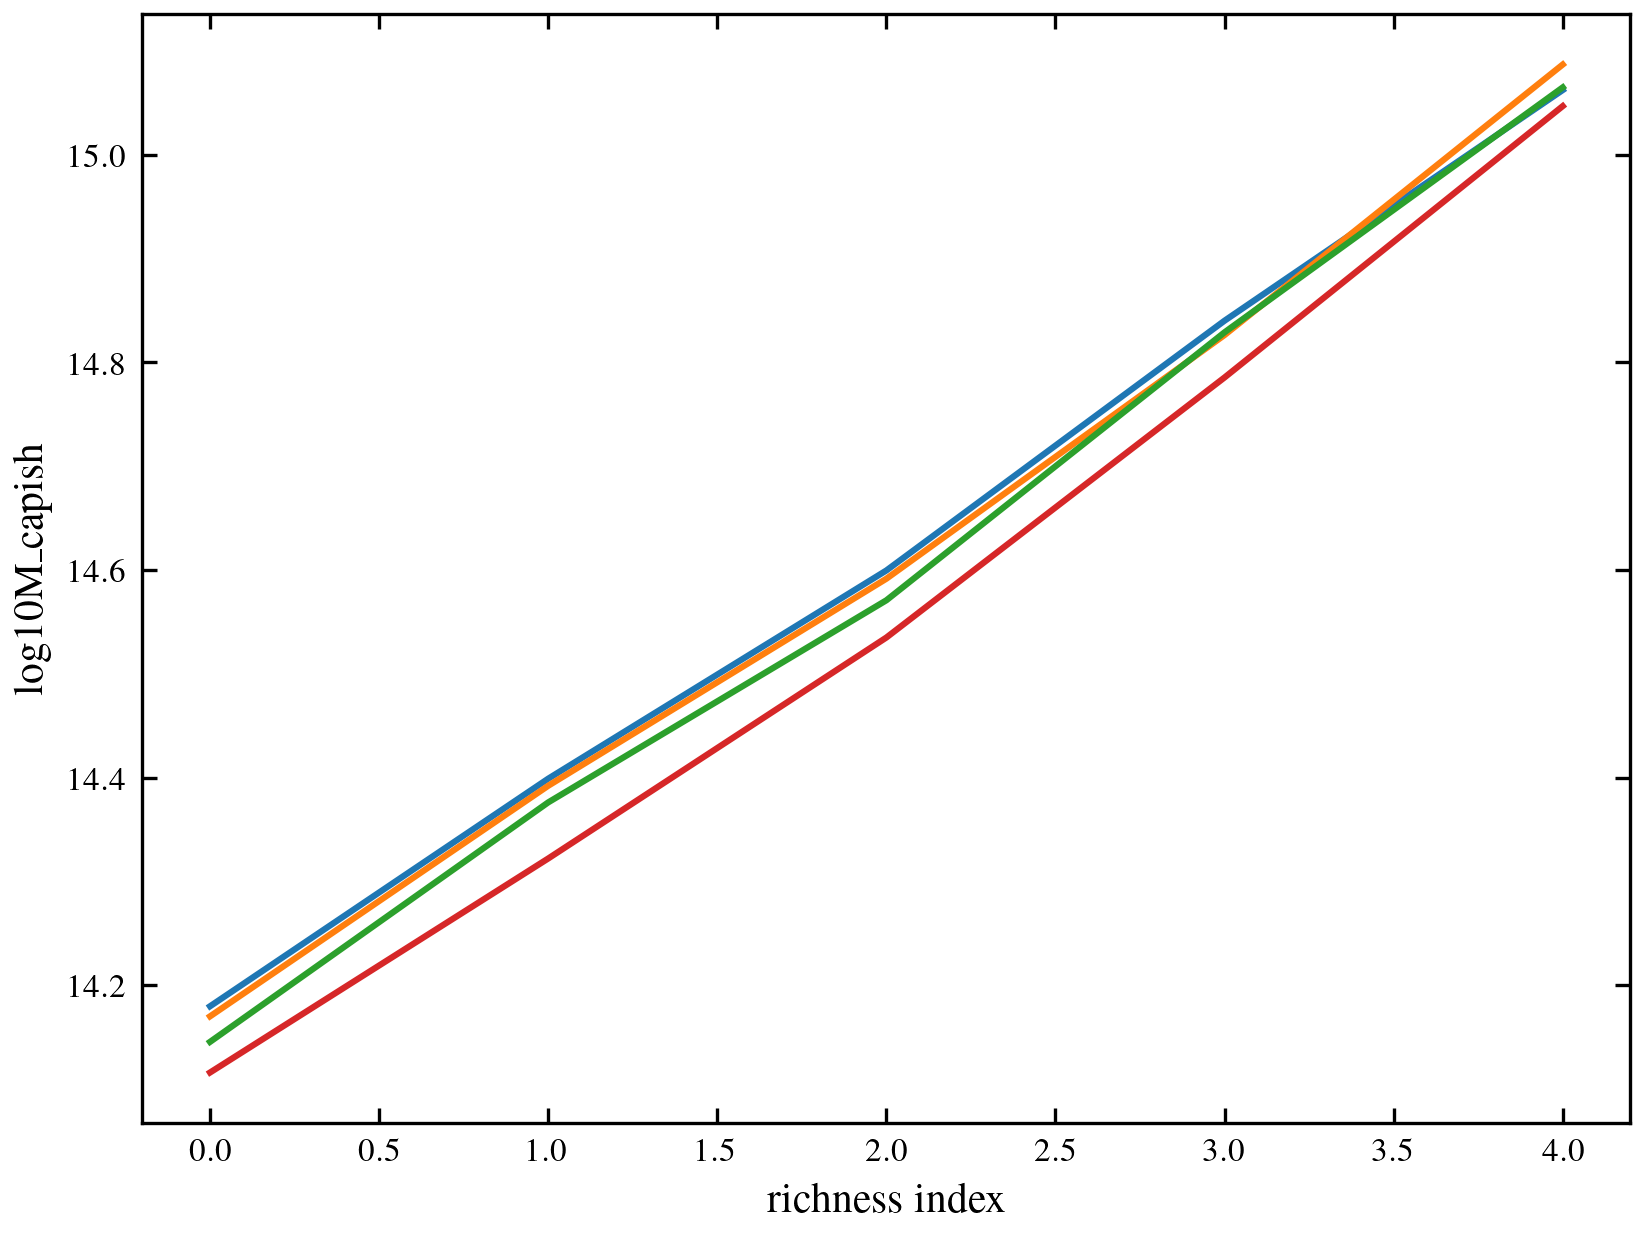

In [7]:
plt.plot(log10M)
plt.xlabel('richness index')
plt.ylabel('log10M_capish')

In [8]:
def mean_obs_relation_DES( log10M, z, params_observable_mean):
        alpha_lambda, beta_lambda, gamma_lambda = params_observable_mean
        # Ensure all are float
        alpha_lambda = float(alpha_lambda)
        beta_lambda = float(beta_lambda)
        gamma_lambda = float(gamma_lambda)

        # Ensure z and log10M are numeric arrays
        z = np.array(z, dtype=float)
        log10M = np.array(log10M, dtype=float)

        # Convert log10M to M, subtract M_min, then back to log10
        M = 10 ** log10M
        M_term = M - 10 ** 11.13

        # Ensure M_term is positive to avoid log of negative numbers
        M_term = np.maximum(M_term, 1e10)  # Set minimum value to avoid log issues

        # Note: This returns ln(lambda), which gets exponentiated later to get lambda
        ln_lambda = np.log(10) * (alpha_lambda + beta_lambda * np.log10(M_term) + gamma_lambda * np.log10(1 + z))
        return ln_lambda

def mean_obs_relation_power_law(log10M, z, params_observable_mean):
    alpha_lambda, beta_lambda, gamma_lambda, log10M_min, z0 = params_observable_mean
    # Ensure all are float
    alpha_lambda = float(alpha_lambda)
    beta_lambda = float(beta_lambda)
    gamma_lambda = float(gamma_lambda)

    z = np.array(z, dtype=float)
    log10M = np.array(log10M, dtype=float)
    
    ln_lambda = alpha_lambda + beta_lambda * (log10M - log10M_min) + gamma_lambda * np.log((1 + z)/(1 + z0))
    return ln_lambda

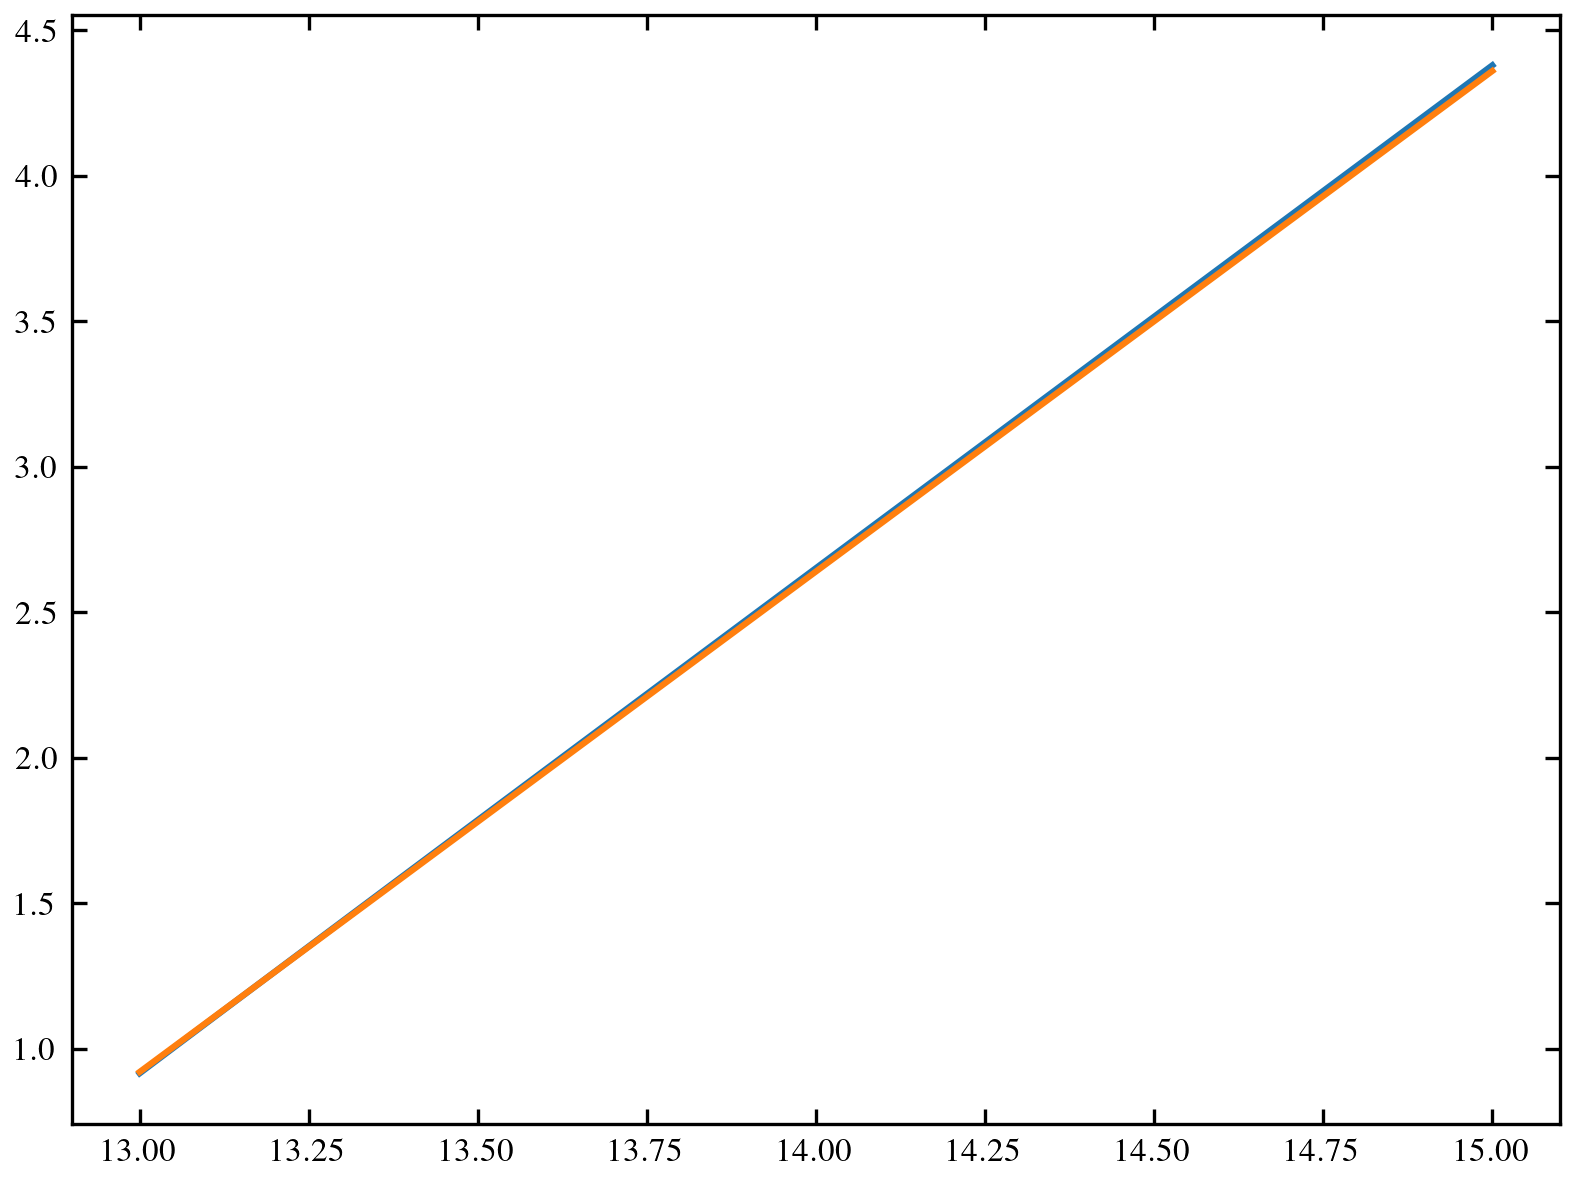

In [9]:
log10m = np.linspace(13, 15, 100)
z=0.5
alpha_lambda = -9.348
beta_lambda = 0.75
gamma_lambda = 0.0
sigma_lambda = 0.3
y1 = mean_obs_relation_DES( log10m, z, [-9.348, 0.75, 0])
plt.plot(log10m,y1)
y2= mean_obs_relation_power_law( log10m, z, [3.5, 1.72, 0, 14.5, 0.5 ])
plt.plot(log10m,y2)

In [10]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/')
from modules.cluster import cluster_catalogue

In [11]:
cl = cluster_catalogue.ClusterCatalogue(default_config_capish)

Loading /pbs/throng/lsst/users/cpayerne/capish/modules/cluster/model_log10mWL_Rmin1.0_Rmax5.0_ngal25.0_ShapeNoise0.3_M200matter_cMDuffy08.pkl


/tmp/ipykernel_20080/2850064799.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


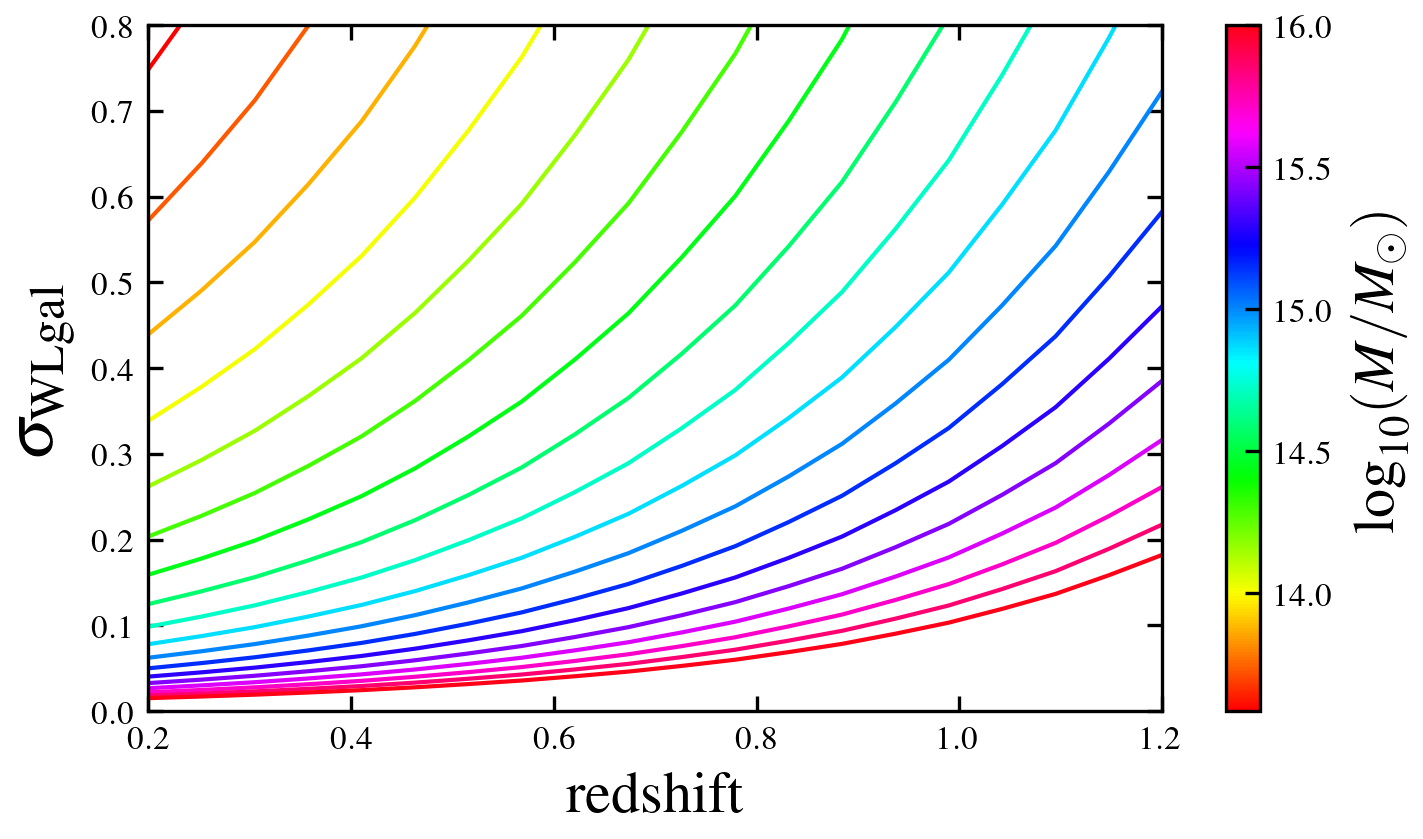

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define colormap based on log10m range
norm = mcolors.Normalize(vmin=np.min(cl.log10m_grid[cl.log10m_grid > 13.5]), vmax=np.max(cl.log10m_grid[cl.log10m_grid > 13.5]))
cmap = cm.hsv  # you can change to 'plasma', 'cividis', etc.
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(5,3))

# Loop through each mass
for i, log10m in enumerate(cl.log10m_grid):
    if log10m < 13.5: continue
    color = sm.to_rgba(log10m)
    plt.plot(
        cl.z_grid,
        cl.sigma_log10M[i, :], '-',
        color=color,
        lw=1
    )


# Add colorbar and labels
cbar = plt.colorbar(sm)
cbar.set_label(r'$\log_{10}(M / M_\odot)$', fontsize=14)
#plt.yscale('log')
plt.ylim(-0., 0.8)
plt.xlabel('redshift', fontsize=14)
plt.ylabel(r'$\sigma_{\rm WLgal}$', fontsize=16)
#plt.hlines(0.2, 0.2, 1.2, color='k', ls='--')
plt.tight_layout()
plt.xlim(0.2, 1.2)
plt.savefig(f'sigmaWL_redshift.png', dpi = 300, bbox_inches='tight',)

/tmp/ipykernel_20080/1462015926.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


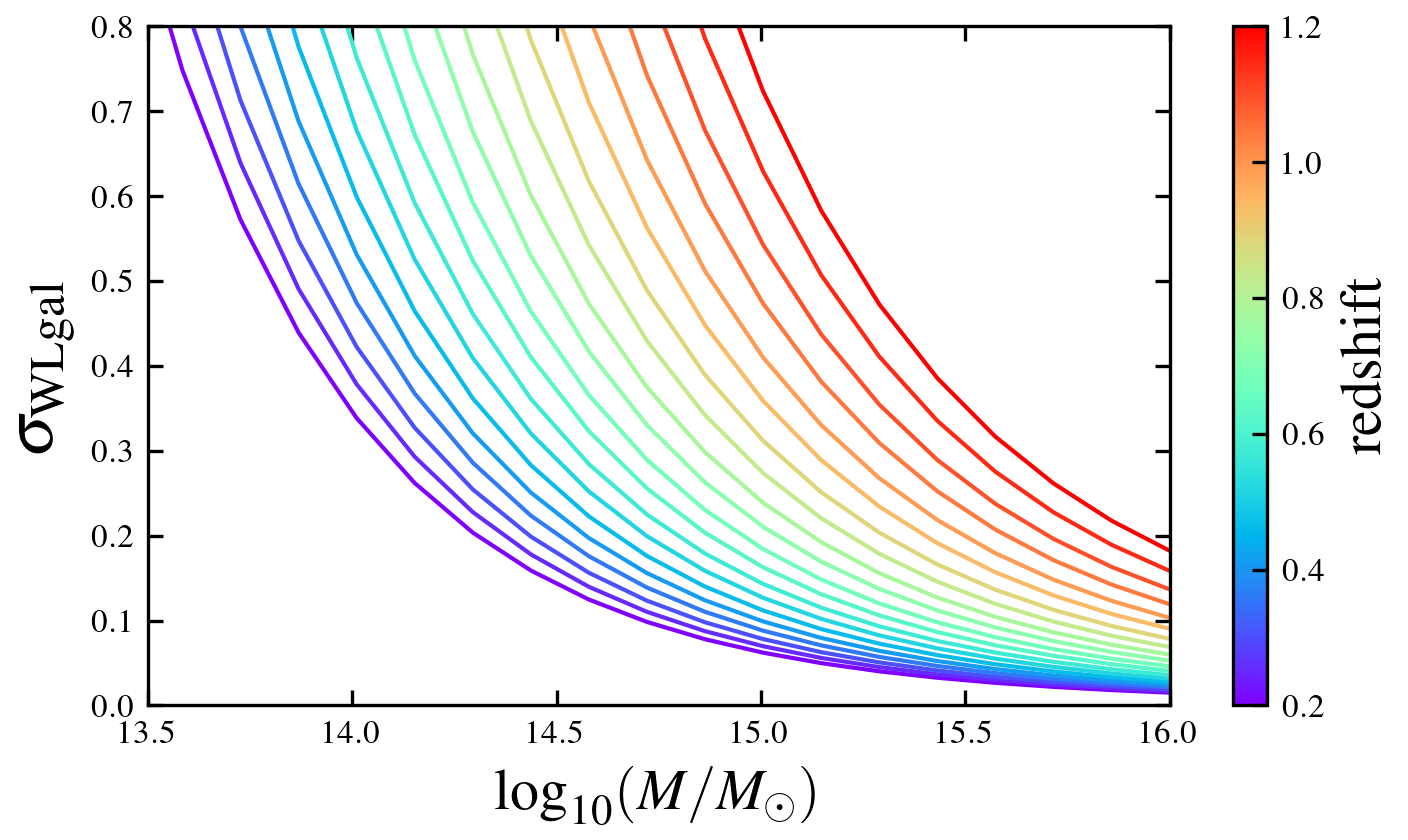

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define colormap based on log10m range
norm = mcolors.Normalize(vmin=np.min(cl.z_grid), vmax=np.max(cl.z_grid))
cmap = cm.rainbow # you can change to 'plasma', 'cividis', etc.
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(5,3))

# Loop through each mass
for i, z in enumerate(cl.z_grid):

    color = sm.to_rgba(z)
    plt.plot(
        cl.log10m_grid,
        cl.sigma_log10M[:,i], '-',
        color=color,
        lw=1
    )


  


# Add colorbar and labels
cbar = plt.colorbar(sm)
cbar.set_label(r'redshift', fontsize=14)
#plt.legend(ncols=1, frameon=True, framealpha=1, loc='upper left', fontsize=14)
#plt.yscale('log')
plt.ylim(-0., 0.8)
plt.xlim(13.5, 16)
plt.xlabel(r'$\log_{10}(M / M_\odot)$', fontsize=14)
plt.ylabel(r'$\sigma_{\rm WLgal}$', fontsize=16)
#plt.hlines(0.2, 0.2, 1.2, color='k', ls='--')
#plt.grid(True, alpha=0.4)
plt.tight_layout()
#plt.xlim(0.2, 1.2)
plt.savefig(f'sigmaWL_halo_mass.png', dpi = 300, bbox_inches='tight',)